# 動的価格調整メカニズムのロバスト性検証シミュレーション

## 目的
初期価格（`initial_price`）の設定ミスに対する、動的価格調整（`gamma` > 0）のロバスト性を検証する。
価格が安すぎる場合や高すぎる場合において、`gamma` による調整が最終的な利益や普及率、余剰にどのような影響を与えるかを確認する。

## パラメータ設定
- Agents: 1000
- Data: 1000
- Initial Price: Log scale (10 - 2000)
- Gamma: [0.0, 0.5, 1.0, 2.0, 3.0, 4.0]

In [6]:
import mesa
from mesa import Model, Agent
from mesa.datacollection import DataCollector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from market_model import DataMarket, Participants
from mesa.batchrunner import batch_run
import os

# グラフのスタイル設定
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meiryo', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

In [7]:
# Bandwagon市場の設定
persona_dist = {
    'Bandwagon': 0.7,
    'Neutral': 0.15,
    'Snob': 0.15
}

w1_params = (2.0, 100)

# 初期価格の範囲設定（対数スケール）
base_prices = np.logspace(
    np.log10(10),     # 10 の log10
    np.log10(2000),   # 2000 の log10
    num=40            # 点の数
)
base_prices = base_prices.round().astype(int)
base_prices =  np.unique(base_prices) # 重複排除

# Gammaの範囲設定
gamma_values = [0.0, 0.5, 1.0, 2.0, 3.0, 4.0]

print(f"Initial Prices ({len(base_prices)}):", base_prices)
print(f"Gamma Values ({len(gamma_values)}):", gamma_values)

Initial Prices (40): [  10   11   13   15   17   20   23   26   30   34   39   45   51   58
   67   77   88  101  115  132  151  173  199  228  261  299  342  392
  449  514  589  675  773  885 1014 1162 1331 1524 1746 2000]
Gamma Values (6): [0.0, 0.5, 1.0, 2.0, 3.0, 4.0]


In [8]:
csv_filename = "results_robustness.csv"

# シミュレーション実行（すでに結果があればスキップも可能だが、今回は常に再実行またはロード）
# 時間がかからないので再実行する、もしくはCSVがあればロードするオプション
run_simulation = True

if os.path.exists(csv_filename):
    print(f"{csv_filename} exists. Loading data...")
    results_df = pd.read_csv(csv_filename)
else:
    print("Starting simulation...")
    all_results = []
    for g in gamma_values:
        print(f"Processing Gamma = {g} ...")
        params = {
            "num_agents": 1000,
            "num_data": 1000,
            "initial_price": base_prices,
            "tau": 0.2,
            "persona_dist": [persona_dist],
            "wealth_alpha": 2.0,
            "wealth_scale": 100,
            "w1_params": [w1_params],
            "seed": 42,
            "dynamic_pricing": True,
            "gamma": g
        }
        
        results = batch_run(
            model_cls=DataMarket,
            parameters=params,
            iterations=1,
            max_steps=50,
            number_processes=None,
            data_collection_period=-1,
            display_progress=False,
        )
        
        for r in results:
            r['gamma'] = g
        
        all_results.extend(results)

    results_df = pd.DataFrame(all_results)
    results_df.to_csv(csv_filename, index=False, encoding="utf-8")
    print("Simulation completed.")

results_df.head()

Starting simulation...
Processing Gamma = 0.0 ...
Processing Gamma = 0.5 ...
Processing Gamma = 1.0 ...
Processing Gamma = 2.0 ...
Processing Gamma = 3.0 ...
Processing Gamma = 4.0 ...
Simulation completed.


,RunId,iteration,Step,num_agents,num_data,initial_price,tau,persona_dist,wealth_alpha,wealth_scale,...,w_1,w_n,alpha,lamb,l_n_minus_1,HasToken,Wealth,Persona,BoughtStep,CurrentUtility
0,1,0,50,1000,1000,11,0.2,"{'Bandwagon': 0.7, 'Neutral': 0.15, 'Snob': 0.15}",2.0,100,...,161.560571,68.327925,0.422925,0.450548,-72.790849,True,99.701367,Neutral,1.0,57.327925
1,1,0,50,1000,1000,11,0.2,"{'Bandwagon': 0.7, 'Neutral': 0.15, 'Snob': 0.15}",2.0,100,...,127.105289,98.416955,0.774295,0.827710,-105.206300,True,105.417781,Bandwagon,1.0,87.416955
2,1,0,50,1000,1000,11,0.2,"{'Bandwagon': 0.7, 'Neutral': 0.15, 'Snob': 0.15}",2.0,100,...,135.092368,115.464589,0.854708,0.741876,-100.221849,True,92.033317,Bandwagon,1.0,104.464589
3,1,0,50,1000,1000,11,0.2,"{'Bandwagon': 0.7, 'Neutral': 0.15, 'Snob': 0.15}",2.0,100,...,279.721816,152.840251,0.546401,0.429240,-120.067739,True,140.761412,Neutral,1.0,141.840251
4,1,0,50,1000,1000,11,0.2,"{'Bandwagon': 0.7, 'Neutral': 0.15, 'Snob': 0.15}",2.0,100,...,105.851052,79.694683,0.752895,0.726787,-76.931167,True,89.411395,Bandwagon,1.0,68.694683


In [9]:
# data_collection_period=-1 なので、最終ステップの値が入っているはず。
final_step = results_df['Step'].max()
final_df = results_df[results_df['Step'] == final_step].copy()

# AgentIDが含まれている場合（Agentごとにデータがある）
if 'AgentID' in final_df.columns:
    # まずRunIdごとに集計
    # Holders, ProviderRevenue, CurrentPrice はModelレベルの変数 (max)
    # ConsumerSurplusはAgentごとのCurrentUtilityの「平均」
    run_data = final_df.groupby(['RunId', 'initial_price', 'gamma']).agg({
        'Holders': 'max', 
        'ProviderRevenue': 'max', 
        'CurrentPrice': 'max', 
        'CurrentUtility': 'mean', # 平均値
        'num_agents': 'max'
    }).reset_index()
    run_data.rename(columns={'CurrentUtility': 'AvgConsumerSurplus'}, inplace=True)
else:
    # Model Reporterのみの場合
    run_data = final_df.copy()
    if 'CurrentUtility' in run_data.columns:
         run_data.rename(columns={'CurrentUtility': 'AvgConsumerSurplus'}, inplace=True)

# 普及率 (Penetration Rate)
run_data['PenetrationRate'] = run_data['Holders'] / run_data['num_agents']

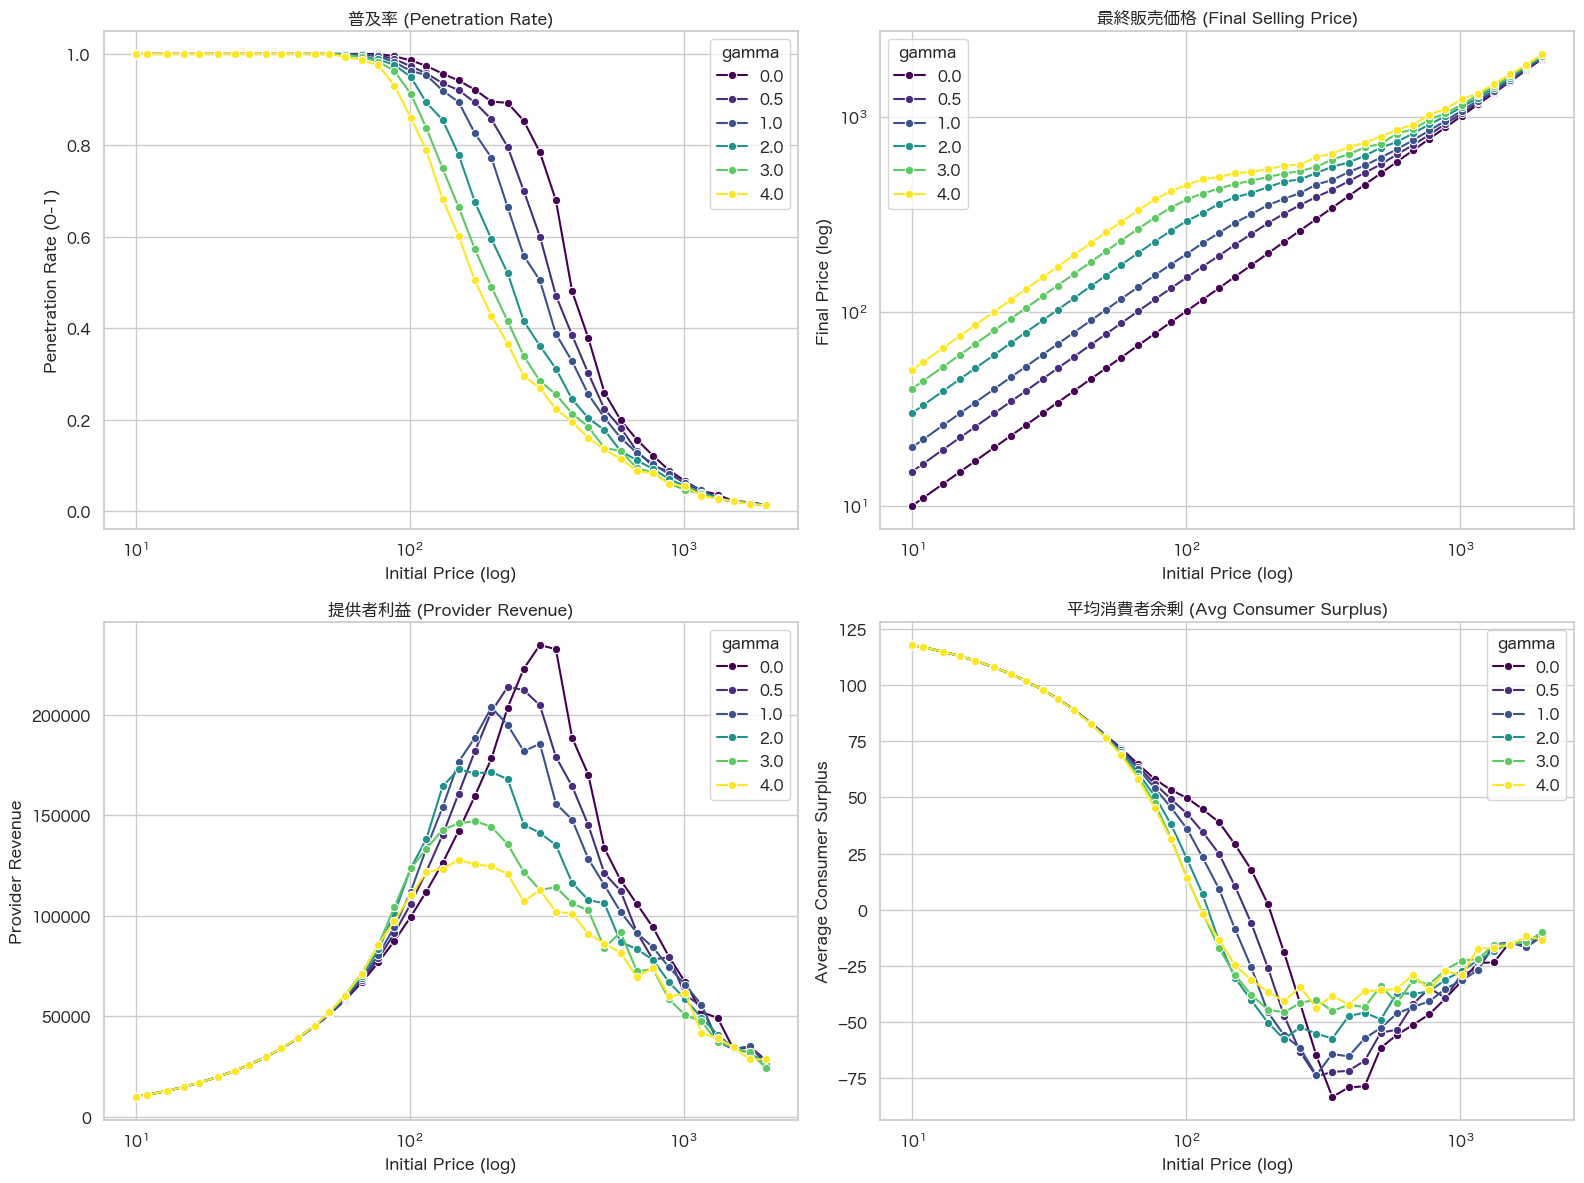

In [10]:
# 可視化 (2x2 Grid)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 普及率 (Top Left)
sns.lineplot(data=run_data, x='initial_price', y='PenetrationRate', hue='gamma', palette='viridis', marker='o', ax=axes[0, 0])
axes[0, 0].set_xscale('log')
axes[0, 0].set_title('普及率 (Penetration Rate)')
axes[0, 0].set_xlabel('Initial Price (log)')
axes[0, 0].set_ylabel('Penetration Rate (0-1)')

# 2. 最終販売価格 (Top Right) - NEW
sns.lineplot(data=run_data, x='initial_price', y='CurrentPrice', hue='gamma', palette='viridis', marker='o', ax=axes[0, 1])
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log') # 価格も大きく変動するのでLogスケールが見やすいかも
axes[0, 1].set_title('最終販売価格 (Final Selling Price)')
axes[0, 1].set_xlabel('Initial Price (log)')
axes[0, 1].set_ylabel('Final Price (log)')

# 3. 提供者利益 (Bottom Left)
sns.lineplot(data=run_data, x='initial_price', y='ProviderRevenue', hue='gamma', palette='viridis', marker='o', ax=axes[1, 0])
axes[1, 0].set_xscale('log')
axes[1, 0].set_title('提供者利益 (Provider Revenue)')
axes[1, 0].set_xlabel('Initial Price (log)')
axes[1, 0].set_ylabel('Provider Revenue')

# 4. 消費者余剰 (Bottom Right)
sns.lineplot(data=run_data, x='initial_price', y='AvgConsumerSurplus', hue='gamma', palette='viridis', marker='o', ax=axes[1, 1])
axes[1, 1].set_xscale('log')
axes[1, 1].set_title('平均消費者余剰 (Avg Consumer Surplus)')
axes[1, 1].set_xlabel('Initial Price (log)')
axes[1, 1].set_ylabel('Average Consumer Surplus')

plt.tight_layout()
plt.savefig('robustness_analysis_v2.png')
plt.show()